In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

# Reading rootpainter's data and isotope data of 2018 and 2019 experiments
data_May18_raw = pd.read_csv("./Data/CLEAN_Wheat3_Full_experiment_root_length.csv")
data_June18_raw = pd.read_csv("./Data/CLEAN_Wheat4_Full_experiment_root_length.csv")
data_July18_raw = pd.read_csv("./Data/CLEAN_Wheat5_Full_experiment_root_length.csv")
isotope_data_18 = pd.read_excel("./Data/isotope_dataframe.xlsx")

data_May19_raw = pd.read_csv("./Data/RadiMax_Wheat_Root_Data_CLEAN_May19.csv")
data_June19_raw = pd.read_csv("./Data/RadiMax_Wheat_Root_Data_CLEAN_June19.csv")
data_July19_raw = pd.read_csv("./Data/RadiMax_Wheat_Root_Data_CLEAN_July19.csv")
isotope_data_19 = pd.read_excel("./Data/Breeders_15N.xlsx")

In [20]:
# Importing RadiMax modules for RLD data preprocessing
from RadiMaxDataPreProcessing import (
    RL_processing,
    fun_RL_computation,
    isotope_data_preprocess,
    plot_RL,
)

# Processing 2018 RL data for getting root lengths from pixels values
data_May18, data_June18, data_July18 = RL_processing(
    data_May18_raw.copy(),
    data_June18_raw.copy(),
    data_July18_raw.copy(),
    Square_root=True,
)

# Processing 2019 RL data for getting root lengths from pixels values
data_May19, data_June19, data_July19 = RL_processing(
    data_May19_raw.copy(),
    data_June19_raw.copy(),
    data_July19_raw.copy(),
    Square_root=True,
)

In [14]:
data_May18

,Camera,tube,Depth,Date,Root_length,soil_depth
0,Cam4,1,1025,16/05/2018,2.152416,81.124319
1,Cam4,1,1055,16/05/2018,1.598513,82.320566
2,Cam4,1,1088,16/05/2018,2.063197,83.636438
3,Cam4,1,1116,16/05/2018,4.193309,84.752935
4,Cam4,1,1147,16/05/2018,8.698885,85.989057
...,...,...,...,...,...,...
32169,Cam1,99,4376,17/05/2018,0.000000,214.745132
32170,Cam1,99,4406,17/05/2018,0.000000,215.941379
32171,Cam1,99,4437,17/05/2018,0.000000,217.177501
32172,Cam1,99,4466,17/05/2018,0.000000,218.333873


In [21]:
#Droping missing Values [np.nan, np.inf, -np.inf]
import warnings
warnings.filterwarnings("ignore")

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

data_May18_RL=data_May18.loc[:,['tube','Root_length','soil_depth']]
data_June18_RL=data_June18.loc[:,['tube','Root_length','soil_depth']]
data_July18_RL=data_July18.loc[:,['tube','Root_length','soil_depth']]
data_May18_RL=clean_dataset(data_May18_RL)
data_June18_RL=clean_dataset(data_June18_RL)
data_July18_RL=clean_dataset(data_July18_RL)

In [7]:
pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.4/220.4 kB 4.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


Tube No: 2


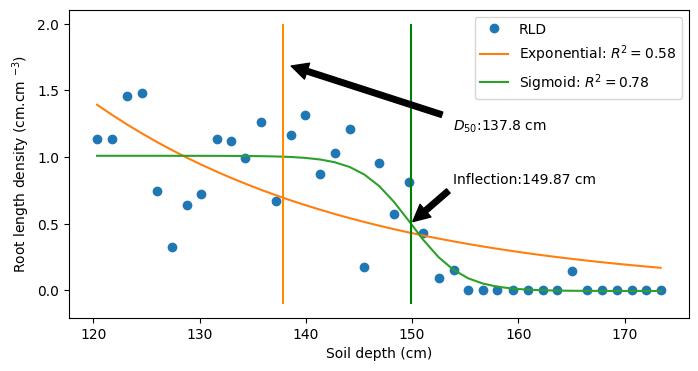

In [24]:

import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
import numpy as np
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

from RadiMaxRootDepth import func_exp,sigmoid,sigmoid_initial_Infle_point,count_consecutive

# Specify month for display results of curve fitting 
data=data_June18_RL.copy()
data.tube=data.tube.astype(int)
for i in [2]:    
    temp1 = data[data.tube==i].sort_values(by='soil_depth')
    x=temp1['soil_depth']
    y=temp1['Root_length'] 
    indx,count=count_consecutive(y, 'zero')
    if count>=6:
        y=np.array(y[0:indx+6].values)
        x=np.array(x[0:indx+6].values)
        temp1=pd.DataFrame([])
        temp1['soil_depth']=x
        temp1['Root_length']=y
        temp1.reset_index(drop=True,inplace=True)
        temp1.dropna(inplace=True)      
        x=pd.Series(x)     
        
    #y=np.sqrt(y) # For square root of RL
    x = (x- x.values[0])/(x.values[-1] - x.values[0])   # normalize    
    print(f'Tube No: {i}')

    popt, pcov =curve_fit(func_exp, x, y,p0=[1,0.1,.11] ,bounds=(0, (np.inf, np.inf, np.inf)),method='trf')
    a, tau,c= popt
    y_fit = func_exp(x, a, tau,c)
    y_pred = func_exp(x, *popt)
    SR1= r2_score(y, y_pred)
 
    #Half-life of Exponentail Decay function 
    xph=np.log(2)/tau    
    #fig, axs = plt.subplots(1, 2)
    fig, ax = plt.subplots(figsize=(8, 4))
    xp_actual=round(xph*(temp1['soil_depth'].values[-1] - temp1['soil_depth'].values[0])+ temp1['soil_depth'].values[0],2)
    half_life=np.append(half_life,xp_actual)
    a_exp_avg=np.append(a_exp_avg,a)
    tau_exp_avg=np.append(tau_exp_avg,tau)
    a=round(a,2)
    tau=round(tau,2)
    ss=str(np.round(xp_actual,1))+" cm"
    xp_lav=round(x*(temp1['soil_depth'].values[-1] - temp1['soil_depth'].values[0])+ temp1['soil_depth'].values[0],2)   
    #xi=sigmoid_initial_Infle_point(x,y) 
    args, cov =curve_fit(sigmoid, x, y,p0=[0.52,5,2,.01],maxfev=10000000,ftol=1e-08, xtol=1e-08,gtol=.00001) 
    x0_sig_inflec,b_sig,L,c=args    
    y_pred = sigmoid(x, *args)
    SR2=r2_score(y, y_pred)
    x0_sig_inflec_actual=round(x0_sig_inflec*(temp1['soil_depth'].values[-1] - temp1['soil_depth'].values[0])+ temp1['soil_depth'].values[0],2)
    s=str(x0_sig_inflec_actual)+" cm"
    ax.plot(xp_lav, y, 'o',xp_lav, y_fit, xp_lav, sigmoid(x, *args),'-')
    ax.set_prop_cycle(color=['red', 'green', 'blue'])
    
    ax.vlines(x=xp_actual, ymin=-0.1, ymax=int(y.max()+1),color='darkorange')
    ax.annotate(r'$D_{50}$:'+ss, xy=(xp_actual, func_exp(xph, a, tau,c)), xytext=(x0_sig_inflec_actual+4, int(y.max()+1)/2+.2),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('Inflection:'+s, xy=(x0_sig_inflec_actual, sigmoid(x0_sig_inflec,x0_sig_inflec,b_sig,L,c)), xytext=(x0_sig_inflec_actual+4, int(y.max()+1)/2-.2),
                 arrowprops=dict(facecolor='black', shrink=0.05))
   #ax.vlines(x=x0_sig_inflec_actual, ymin=-0.1, ymax=int(y.max()+1),color='red')
    ax.vlines(x=x0_sig_inflec_actual, ymin=-0.1, ymax=int(y.max()+1),color='green')
    ax.legend(['RLD',r'Exponential: $R^{2}=$'+str(np.round(SR1,2)),r'Sigmoid: $R^{2}=$'+str(np.round(SR2,2))])
  #  plt.title('June 2018: Tube No. '+ str(i))

    ax.set_xlabel('Soil depth (cm)')
    ax.set_ylabel(r'Root length density (cm.cm $^{-3}$)')
  
    plt.show()
     # Save each figure as a pdf file.


